In [4]:
from module.utils import load_token_mapping
from collections import defaultdict
from tqdm import tqdm

In [5]:
aug_q = load_token_mapping('data/mt_aug/queries')
aug_s = load_token_mapping('data/mt_aug/sups')

In [ ]:
mt_q = load_token_mapping('data/mt/queries')
mt_s = load_token_mapping('data/mt/sups')

In [ ]:
aug_s_set = set(aug_s[0])
mt_s_set = set(mt_s[0])
not_in_aug_s = list(mt_s_set - aug_s_set)

In [ ]:
aug_q_set = set(aug_q[0])
mt_q_set = set(mt_q[0])

In [ ]:
not_in_aug_q = mt_q_set - aug_q_set

In [ ]:
not_in_aug_q = list(not_in_aug_q)

In [ ]:
def minDistance(word1: str, word2: str) -> int:
    n1 = len(word1)
    n2 = len(word2)
    dp = [[0] * (n2 + 1) for _ in range(n1 + 1)]
    # 第一行
    for j in range(1, n2 + 1):
        dp[0][j] = dp[0][j-1] + 1
    # 第一列
    for i in range(1, n1 + 1):
        dp[i][0] = dp[i-1][0] + 1
    for i in range(1, n1 + 1):
        for j in range(1, n2 + 1):
            if word1[i-1] == word2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = min(dp[i][j-1], dp[i-1][j], dp[i-1][j-1] ) + 1
    #print(dp)      
    return dp[-1][-1]

def isOneEditDistance(s: str, t: str) -> bool:
    distance = len(s) - len(t)
    if abs(distance) > 1:
        return False
    if not s or not t:
        return s != t
    
    edit = 0
    i,j = 0,0
    while i < len(s) and j < len(t):
        if s[i] == t[j]:
            i += 1
            j += 1
        else:
            if edit:
                return False

            if distance == 1: # 删除
                i += 1
            elif distance == -1:  # 插入
                j += 1
            else:   # 替换
                i += 1
                j += 1 
            edit += 1
    if i < len(s):
        return edit == 0
    if j < len(t):
        return edit == 0
    return i == len(s) and j == len(t) and edit == 1




In [ ]:

q_dict = defaultdict(list)
for nq in tqdm(not_in_aug_q[:100]):
    for aq in aug_q_set:
        dist = isOneEditDistance(nq, aq)
        if dist:
            q_dict[nq].append(aq)

100%|██████████| 100/100 [00:27<00:00,  3.57it/s]


In [ ]:
q_dict.keys()

dict_keys(['牛奶12', '菊花开', '猪脚饭', '酒精小支', '甜蜜脆西瓜', '咸柠汽水', '小孩套装', '蟹黄炒饭', '外婆香菜子油', '电热吹风机', '护理垫大', '中筒棉袜子', '要饮料', '煮面调料包', '香脆果', '强力脑清片', '冈本004', '海天豪油', '病人床', '开边蝉蛹', '袋装杏仁', '麻辣肺片', '一次性红色塑料袋', '红糖水暖宫贴', '草莓礼袋', '螺丝泡面', '六味地黄丸360粒', '抹茶奶绿', '慢严舒柠喉爽糖', '打底毛衣', '氨甲苯酸', '迷你手持风扇', '润滑油袋', '保鲜袋带封口', '燕麦小米', '丘比特芝麻', '优盘转换头', '紫薯麻薯面包', '冰冻鲍鱼', '猫咪浴巾', '桶装红酒', '有鱼猫条', '无糖杂粮饼干', '分割刀', '水果巧克力花', '鞋柜子', '儿童洗发帽', '巧克力冰激淋蛋糕', '氯化锌软膏'])

In [ ]:
q_dict['无糖杂粮饼干']

['无糖粗粮饼干']

In [ ]:
s_dict = defaultdict(list)
for ns in tqdm(not_in_aug_s[:4]):
    for _as in aug_s_set:
        dist = isOneEditDistance(ns, _as)
        if dist:
            s_dict[ns].append(_as)

100%|██████████| 4/4 [00:49<00:00, 12.44s/it]


Test Val 度数分析

In [ ]:
import dgl
import torch
from module import load_token_mapping
from collections import Counter

In [ ]:
i2q, q2i  = load_token_mapping('data/mt_new/queries')
i2s, s2i = load_token_mapping('data/mt_new/spus')
s2i = {k: v + len(q2i) for k, v in s2i.items()}

graph, _ = dgl.load_graphs('data/mt_new/pos_neg_train.graph')
graph = graph[0]
pos_g = dgl.to_homogeneous(graph['pos'])
pos_g = dgl.to_bidirected(pos_g)

In [ ]:
graph['neg'].num_edges()

785168

In [ ]:
graph['pos'].num_edges()

1151352

In [ ]:
graph.in_degrees(etype='pos')

tensor([1, 0, 1,  ..., 1, 0, 1])

In [ ]:
def degree_stat(f_path, graph):
    queries, spus = set(), set()
    with open(f_path, 'r') as f:
        for line in f:
            q, s, l = line.strip().split('\t')
            # if int(l) == 1:
            q = q.strip()
            s = s.strip()
            queries.add(q2i[q])
            spus.add(s2i[s])
    queries = list(queries)
    spus = list(spus)
    return graph.in_degrees(queries), graph.in_degrees(spus)

def load_data(f_path):
    data = set()
    with open(f_path, 'r') as f:
        for line in f:
            q, s, l = line.strip().split('\t')
            # if int(l) == 1:
            l = int(l)
            q = q.strip()
            s = s.strip()
            data.add((q, s, l))
    return data


In [ ]:
train_q, train_s = degree_stat('data/mt_new/new_train', pos_g)

In [ ]:
print(torch.mean(train_q.float()), torch.mean(train_s.float()))

tensor(5.8975) tensor(0.8330)


In [ ]:
val_q, val_s = degree_stat('data/mt_new/new_val', pos_g)
test_q, test_s = degree_stat('data/mt_new/new_test', pos_g)

In [ ]:
print(torch.mean(torch.cat((val_q, val_s), dim=-1).float()))
print(torch.mean(torch.cat((test_q, test_s), dim=-1).float()))

tensor(4.2065)
tensor(2.8082)


In [ ]:
print(torch.mean(val_q.float()), torch.mean(val_s.float()))
print(torch.mean(test_q.float()), torch.mean(test_s.float()))

tensor(14.7463) tensor(0.6645)
tensor(15.0414) tensor(0.5158)


In [ ]:
print(val_q.shape, val_s.shape, test_q.shape, test_s.shape)

torch.Size([66676]) torch.Size([198408]) torch.Size([47567]) torch.Size([253833])


In [ ]:
val_q_cnt = Counter(val_q.tolist())
test_q_cnt = Counter(test_q.tolist())

In [ ]:
val_q_cnt.most_common(10)

[(0, 23755),
 (1, 6591),
 (2, 3797),
 (3, 2753),
 (4, 2222),
 (5, 1801),
 (6, 1406),
 (7, 1250),
 (8, 1195),
 (18, 1103)]

In [ ]:
test_q_cnt.most_common(10)

[(0, 19705),
 (1, 4847),
 (2, 3137),
 (3, 2231),
 (4, 1731),
 (5, 1351),
 (6, 1020),
 (7, 801),
 (8, 757),
 (9, 614)]

In [ ]:
train_data = load_data('data/mt_new/new_train')
val_data = load_data('data/mt_new/new_val')
test_data = load_data('data/mt_new/new_test')

In [ ]:
print(len(train_data.intersection(val_data)))
print(len(train_data.intersection(test_data)))

29
5


# sbert embedding相似度分析

In [ ]:
import torch
from module import SentenceBert
from chanfig import Config
import torch.nn.functional as F

In [ ]:
config = Config.load('ckpt/mt_new/sbert_2022-12-08_16:20:57/config.yml')
model = SentenceBert(config)
model.load_state_dict(torch.load('ckpt/mt_new/sbert_2022-12-08_16:20:57/model.bin'))

No sentence-transformers model found with name /mnt/dolphinfs/hdd_pool/docker/user/hadoop-aipnlp/yangyang113/distillation_clean/plms/smallbert_yuji/auto-medium/. Creating a new one with MEAN pooling.


<All keys matched successfully>

In [ ]:
sents = model.encode(['苹果13p最新款苹果', '苹果14p最新款苹果', '苹果13', '苹果14', '苹果13promax6.7抗冲击全屏抗击高分子防碎边手机膜/1个'])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
sents.shape

torch.Size([2, 384])

In [ ]:
F.cosine_similarity(sents[0].view(1, -1), sents[1].view(1, -1))

tensor([0.9463])

# q2s对比学习和sbert测试集case对比

In [ ]:
def read_data(path):
    data = set()
    with open(path, 'r') as f:
        for line in f:
            q, s, l = line.strip().split('\t')
            data.add((q, s, l))
    return data

In [ ]:
q2s_data = read_data('ckpt/mt_new/sbert_distill_cont_2023-02-16_22:57:11/mis_pred.txt')
sbert_data = read_data('ckpt/mt_new/sbert_2023-02-16_23:06:29/mis_pred.txt')

In [ ]:
len(q2s_data)

47618

In [ ]:
len(sbert_data)

49907

In [ ]:
q2s_better = sbert_data - q2s_data
sbert_better = q2s_data - sbert_data

In [ ]:
q2s_better

{('酸乳', '伊利优酸乳原味乳饮料250ml*24(新老包装随机发货)', '1'),
 ('乌梅丸', '[何不爽]乌梅150g/瓶', '1'),
 ('蚊蝇香', '黑猫神檀香', '0'),
 ('钙水', '白云山和黄医药亨乐维氏水苏糖乳钙压片糖果（1克/粒*60粒）60克/盒xs', '0'),
 ('超长夜用卫生巾', '花王乐而雅零触感特薄0.1cm夜用卫生巾30cm*8片', '0'),
 ('葯', '锁鲜鸭锁骨【大盒】', '0'),
 ('爆款秒杀', 'ss手工制作九味茯苓山药薏湿糕250克伏湿糕抖音网红爆款', '0'),
 ('健身', '日式油醋汁0脂肪油醋汁脱脂减脂水果蔬菜油醋汁低脂酱料健身无脂调味料', '0'),
 ('数字气球', '【数字可以更换两个】气球套餐派对背景墙装饰布置教室幼儿园气球装饰用品', '1'),
 ('卡通创口贴', '约斯夫高弹防水透气型创口贴5贴', '0'),
 ('甘草好果', '甘草脆柿', '1'),
 ('五金', '更换玻璃窗户玻璃断桥铝玻璃上门更换免费量尺', '1'),
 ('红薯粉', '味好美孜然粉28g/瓶', '0'),
 ('善存男士', '络华xxl男士时尚平角裤2条(颜色随机)', '0'),
 ('紫归油', '[华润天和]紫归治裂膏5cm*7cm*8贴/盒', '0'),
 ('益春', '[春柏]健脑益气片3.4g*20片*3板/盒', '0'),
 ('温胃', '土豆丝卷饼', '0'),
 ('自慰女性', '七度空间少女系列275mm超薄纯棉加长日用卫生巾11片', '0'),
 ('诺贝尔', '全口内窥镜检查+口腔全景片检查', '1'),
 ('小黄鱼', '黄花鱼条约400g（冰鲜）', '0'),
 ('象棋', '儿童围棋套装中小学生五子棋象棋初学者19路棋盘黑白仿玉棋南极人', '1'),
 ('黑椒牛柳', '联豪冷冻黑椒牛仔骨300g', '0'),
 ('通络骨质宁膏', '[仁和中方]骨友灵贴膏7cm*10cm*3贴*2袋/盒', '0'),
 ('橄榄果', '石橄榄100g', '1'),
 ('梅干菜', '六必居咸菜梅菜笋丝70g*10袋即食下饭小菜', '0'),
 ('糯米', '宫廷江米条', '0'),
 ('小吃'

In [ ]:
spu_len = 0
for d in q2s_better:
    spu_len += len(d[1])
spu_len / len(q2s_better)

19.110200024847806

In [ ]:
spu_len = 0
for d in sbert_better:
    spu_len += len(d[1])
spu_len / len(q2s_better)

16.47695365883961

In [ ]:
spu_len = 0
for d in sbert_data:
    spu_len += len(d[1])
spu_len / len(q2s_better)

58.295067710274566

In [ ]:
spu_len = 0
for d in q2s_data:
    spu_len += len(d[1])
spu_len / len(q2s_better)

55.66182134426637

# SPU-SPU图

In [1]:
import dgl
from dgl import load_graphs
import torch
from module import load_token_mapping
from sentence_transformers import SentenceTransformer
import dgl.function as fn

In [2]:
g, _ = load_graphs('data/mt_new/train_s2s_mtbert_cos_sim_0.96.graph')
g = g[0]

In [3]:
g.num_nodes()

1678075

In [2]:
g, _ = load_graphs('data/mt_new/train_s2s.graph')
g = g[0]

In [3]:
g_new = dgl.remove_self_loop(g)
g_new = g_new
cos_sim = torch.load('data/mt_new/train_s2s_noselfloop_edge_cossim.pt')

In [11]:
src, dst = g_new.edges()
indegrees = g_new.in_degrees()
mask = (indegrees[src] <= 40) | (indegrees[dst] <= 40) | (cos_sim.flatten() > 0.95).cpu()

In [12]:
g_sub = dgl.edge_subgraph(g_new, mask, relabel_nodes=False)
g_sub = dgl.add_self_loop(g_sub)
dgl.save_graphs('data/mt_new/train_s2s_mtbert_edge>40_cos_sim_0.95.graph', [g_sub], None)

In [13]:
print(torch.mean(g_sub.in_degrees().float()))
print(torch.max(g_sub.in_degrees().float()))
print(torch.median(g_sub.in_degrees().float()))
print(torch.quantile(g_sub.in_degrees().float(), q=0.9))

tensor(87.8105)
tensor(11339.)
tensor(2.)
tensor(110.)


In [4]:
spus, _ = load_token_mapping('data/mt_new/spus')

In [ ]:
# sbert = SentenceTransformer('/mnt/dolphinfs/hdd_pool/docker/user/hadoop-aipnlp/yangyang113/distillation_clean/plms/smallbert_yuji/auto-medium/')
# spu_emb = sbert.encode(spus, convert_to_tensor=True, device='cuda', show_progress_bar=True)
# torch.save(spu_emb, 'data/mt_new/spu_emb_mt_bert_mean_pooling.pt')

No sentence-transformers model found with name /mnt/dolphinfs/hdd_pool/docker/user/hadoop-aipnlp/yangyang113/distillation_clean/plms/smallbert_yuji/auto-medium/. Creating a new one with MEAN pooling.


In [5]:
spu_emb = torch.load('data/mt_new/spu_emb_mt_bert_mean_pooling.pt')

In [6]:
spu_emb.shape

torch.Size([1678075, 384])

In [6]:
g_new = dgl.remove_self_loop(g)

In [7]:
max_degree_idx = torch.argmax(g_new.in_degrees())


In [9]:
max_degree_idx

tensor(351079)

In [8]:
g_new = g_new.to('cuda:1')

In [10]:
g_new.ndata['emb'] = spu_emb.to('cuda:1')

In [11]:
g_new.apply_edges(fn.u_dot_v('emb', 'emb', 'x'))

In [12]:
g_new.edata['x'].shape

torch.Size([778439768, 1])

In [15]:
g_new.ndata['norm'] = torch.linalg.norm(g_new.ndata['emb'], dim=-1)

In [17]:
del spu_emb
del g_new.ndata['emb']

In [18]:
g_new.apply_edges(fn.u_mul_v('norm', 'norm', 'norm'))

In [19]:
g_new.edata['x'].shape

torch.Size([778439768, 1])

In [23]:
torch.cuda.empty_cache()

In [21]:
g_new = g_new.to('cuda:2')

In [27]:
cos_sim = (g_new.edata['x'].to('cuda:3')) / (g_new.edata['norm'].to('cuda:3')).view(-1, 1)

In [30]:
torch.mean(cos_sim)
torch.save(cos_sim, 'data/mt_new/train_s2s_edge_cossim.pt')

In [31]:
in_edges = g_new.in_edges(int(max_degree_idx), form='eid')
cos_sim = cos_sim[in_edges]

In [33]:
cos_sim.mean()

tensor(0.8805, device='cuda:3')

In [23]:
torch.sum((g_new.edata['cos'] > 0.96).to('cuda:1'))

tensor(64086854, device='cuda:1')

In [ ]:
g_new.edata['cos'].shape

torch.Size([778439768, 1])

In [ ]:
g_sub = dgl.edge_subgraph(g_new, (g_new.edata['cos'] > 0.96).flatten(), relabel_nodes=False)

In [ ]:
torch.mean(g_sub.in_degrees().float())

tensor(38.1907, device='cuda:1')

In [ ]:
g_sub, _ = load_graphs('data/mt_new/train_s2s_mtbert_cos_sim_0.96.graph')
g_sub = g_sub[0]
g_sub = dgl.add_self_loop(g_sub)
dgl.save_graphs('data/mt_new/train_s2s_mtbert_cos_sim_0.96.graph', [g_sub], None)

In [ ]:
g_new

Graph(num_nodes=1678075, num_edges=778439768,
      ndata_schemes={'_TYPE': Scheme(shape=(), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64), 'norm': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'_TYPE': Scheme(shape=(), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64), 'x': Scheme(shape=(1,), dtype=torch.float32), 'cos': Scheme(shape=(1,), dtype=torch.float32), 'norm': Scheme(shape=(), dtype=torch.float32)})

# spu-spu图邻居查看

In [1]:
import dgl
from dgl import load_graphs
import torch
from module import load_token_mapping
from sentence_transformers import SentenceTransformer
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [3]:
spus, _ = load_token_mapping('data/mt_new/spus')


In [2]:
g_cos96, _ = load_graphs('data/mt_new/train_s2s_mtbert_cos_sim_0.96.graph')
g_cos96 = g_cos96[0]

In [4]:
print(torch.mean(g_cos96.in_degrees().float()))
print(torch.max(g_cos96.in_degrees().float()))
print(torch.median(g_cos96.in_degrees().float()))
print(torch.quantile(g_cos96.in_degrees().float(), q=0.5))

tensor(39.1907)
tensor(7894.)
tensor(1.)
tensor(17.)


In [6]:
max_degree_idx = torch.argmax(g_cos96.in_degrees())
# print(spus[max_degree_idx])
spu_idx = max_degree_idx
neigh_case = g_cos96.predecessors(spu_idx)
tgt_spu = spus[spu_idx]
neigh_spu = [spus[i] for i in neigh_case.tolist()]
print(tgt_spu)
print(neigh_spu)

【告白气球】11朵香槟玫瑰鲜花束送爱人女神同城花店配送
['【手提花篮】33朵粉玫瑰鲜花手提花篮送老婆礼物', '【如花似锦】11朵粉玫瑰鲜花束送女友送朋友花店送花上门', '【郁金香】6朵橙色郁金香花束送女神妇女节鲜花', '【店铺热销】11朵粉玫瑰鲜花束送女友送爱人同城鲜花店', '33朵红玫瑰花束款送女友惊喜生日鲜花花束花店', '一生有你11朵粉玫瑰花迷你小花束简易包装致爱人配手提袋', '千朵鲜花-经典红色玫瑰熊送闪灯', '【月亮代表我的心】鲜花束送爱人恋人礼物同城花店配送', '【三生三世】33朵红玫瑰皇冠串灯鲜花花束', '【爱你心口难开】蓝色满天星花束送女友送爱人生日礼物鲜花店配送', '【日常家居花】鲜花10枝香槟玫瑰5019款', '白色情人节11支红玫瑰鲜花花束送女神送老婆送女友同城花店送货上门', '【守望爱情】七彩满天星鲜花花束高口碑爆款情人节礼物', '爱你如初-11朵红玫瑰鲜花束送爱人惊喜礼物鲜花店送花上门', '【佳人才子】19朵红玫瑰鲜花束礼盒送爱人女友节日礼物同城送', '♥为爱痴狂♥11枝红玫瑰搭配尤加利花束☄☄☄☄', '【独宠一人】-鲜花满天星9枝粉玫瑰花混合女神节花束送女友-916a', '浪漫星辰/满天星粉玫瑰混搭网红花束/礼品礼物★', '俩情相悦11朵玫瑰花草莓鲜花花束/过生日送闺蜜花店送花上门', '【余生都是你】19朵红玫瑰礼盒送爱人生日礼物同城花店', '【飞星传情】表白鲜花11朵玫瑰花同城配送送爱人送女友白月光', '19朵新娘手捧花4选一同城鲜花配送', '【老婆我爱你】百合情人草21支红玫瑰鲜花花束', '【送亲友礼物】11朵香槟玫瑰手提花篮生日送上门女友节同城花店', '【浪漫情怀】11支红玫瑰送女友送爱人生日鲜花送花上门', '【巴黎春天】19枝红玫瑰鲜花花束送女友爱人闺蜜', '【永远爱你】11朵红玫瑰花时尚鲜花礼盒鲜花店送花上门', '【惊喜礼物】粉色满天星送女友爱人女神节鲜花免费送花上门', '【爱你1314】19朵玫瑰混搭鲜花礼盒送女友表白花店送花上门', '【红玫相思】99朵红玫瑰鲜花束送女友花店送', '【恋恋繁星】11只香槟玫瑰礼盒送男女朋友情人节鲜花惊喜礼物', '【爱的约定】11枝红玫瑰花鲜花花束花店鲜花生日鲜花', '【送爱人】甜蜜相爱（香槟玫瑰韩式花束）', '【情人节女神款】

In [ ]:
g, _ = load_graphs('data/mt_new/train_s2s.graph')
g = g[0]

In [34]:
print(torch.mean(g.in_degrees().float()))
print(torch.max(g.in_degrees().float()))
print(torch.median(g.in_degrees().float()))
print(torch.quantile(g.in_degrees().float(), q=0.8))

tensor(464.8886)
tensor(24998.)
tensor(3.)
tensor(107.)


In [35]:
max_degree_idx = torch.argmax(g.in_degrees())

In [36]:
spus[max_degree_idx]

'创意鲜花19支草莓花束生日礼物送女友送爱人送闺蜜水果花束'

(array([1.605005e+06, 2.461100e+04, 1.239900e+04, 1.096800e+04,
        1.056400e+04, 1.026000e+04, 4.216000e+03, 4.500000e+01,
        4.000000e+00, 3.000000e+00]),
 array([1.00000e+00, 2.50070e+03, 5.00040e+03, 7.50010e+03, 9.99980e+03,
        1.24995e+04, 1.49992e+04, 1.74989e+04, 1.99986e+04, 2.24983e+04,
        2.49980e+04]),
 <BarContainer object of 10 artists>)

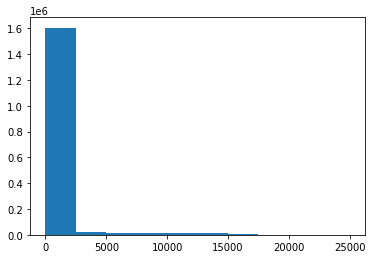

In [29]:
plt.hist(g.in_degrees())

In [37]:
# spu_idx = 111412
spu_idx = max_degree_idx
neigh_case = g.predecessors(spu_idx)

In [38]:
tgt_spu = spus[spu_idx]
neigh_spu = [spus[i] for i in neigh_case.tolist()]